In [ ]:
# CELL 1: SETUP AND INSTALLATIONS
# =============================================================================
print("--- Preparing Environment ---")

# Step 1: Uninstall conflicting packages. This is necessary because some pre-installed
# libraries in Colab have dependency requirements that clash with rdkit.
!pip uninstall -y opencv-python-headless thinc albumentations albucore spacy

# Step 2: Install project-specific libraries.
# We pin numpy to a version compatible with rdkit.
!pip install -q 'numpy<2.0'

# FIX: Use the correct, modern package name for RDKit
!pip install -q rdkit

!pip install -q torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install -q torch-geometric
!pip install -q pandas scikit-learn matplotlib seaborn tqdm

print("\n✅ Installation complete.")
print("‼️ IMPORTANT: Please restart the runtime now before proceeding. (Runtime -> Restart session)")

--- Preparing Environment ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 48.1 MB/s eta 0:00:00

✅ Installation complete.
‼️ IMPORTANT: Please restart the runtime now before proceeding. (Runtime -> Restart session)


In [ ]:
# =============================================================================
# CELL 2: IMPORTS AND CONFIGURATION
# =============================================================================
print("--- Importing Libraries ---")
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import AllChem

# PyTorch and PyTorch Geometric
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool

# Scikit-learn for evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

# Configuration
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✅ Libraries imported successfully.")
print(f"Using device: {device}")

--- Importing Libraries ---
✅ Libraries imported successfully.
Using device: cuda


In [ ]:
# =============================================================================
# CELL 3: LOAD DATASET
# =============================================================================
print("--- Downloading and Loading Dataset ---")
DATASET_URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz"
DATASET_NAME = "clintox.csv.gz"

if not os.path.exists(DATASET_NAME):
    !wget -q {DATASET_URL}

df = pd.read_csv(DATASET_NAME)
print("Dataset loaded.")

# Data Cleaning: Drop rows with missing SMILES strings or labels
df.dropna(subset=['smiles', 'CT_TOX'], inplace=True)

print(f"\nDataset Shape: {df.shape}")
print(f"Class Distribution:\n{df['CT_TOX'].value_counts()}")
print("\nDataset Preview:")
df.head()

--- Downloading and Loading Dataset ---
Dataset loaded.

Dataset Shape: (1484, 3)
Class Distribution:
CT_TOX
0    1372
1     112
Name: count, dtype: int64

Dataset Preview:


,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [ ]:
# =============================================================================
# CELL 4: FEATURE ENGINEERING AND DATASET CREATION
# =============================================================================
def get_atom_features(atom):
    """Generates a feature vector for a single atom."""
    features = [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetHybridization(),
        atom.GetIsAromatic(),
        atom.GetTotalNumHs(),
        atom.GetNumRadicalElectrons(),
        atom.IsInRing(),
        atom.GetChiralTag()
    ]
    return torch.tensor(features, dtype=torch.float)

def smiles_to_graph(smiles_string, y_label):
    """Converts a SMILES string to a PyTorch Geometric Data object."""
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None: return None

    # Node features
    atom_features_list = [get_atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.stack(atom_features_list, dim=0)

    # Edge connectivity
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices.extend([[i, j], [j, i]])
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Label
    y = torch.tensor([y_label], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, y=y)

# Process all molecules into a list of graph Data objects
print("Processing molecules into graphs...")
data_list = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    graph_data = smiles_to_graph(row['smiles'], row['CT_TOX'])
    if graph_data:
        data_list.append(graph_data)

print(f"\n✅ Successfully processed {len(data_list)} molecules into graphs.")

Processing molecules into graphs...


  0%|          | 0/1484 [00:00<?, ?it/s]

[10:09:32] Explicit valence for atom # 0 N, 4, is greater than permitted
[10:09:32] Can't kekulize mol.  Unkekulized atoms: 9
[10:09:33] Can't kekulize mol.  Unkekulized atoms: 4
[10:09:33] Can't kekulize mol.  Unkekulized atoms: 4



✅ Successfully processed 1480 molecules into graphs.


In [ ]:
# =============================================================================
# CELL 5: DEFINE THE GAT MODEL
# =============================================================================
class GATNet(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, num_heads=8, dropout=0.6):
        super(GATNet, self).__init__()
        self.dropout = dropout

        self.conv1 = GATConv(num_node_features, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=dropout)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels * num_heads, hidden_channels),
            nn.ELU(),
            nn.Linear(hidden_channels, num_classes)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GAT layers
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        # Pooling and classification
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        output = self.classifier(x)

        return output

print("✅ GATNet model class defined.")

✅ GATNet model class defined.


In [ ]:
# =============================================================================
# CELL 6: PREPARE FOR TRAINING (Corrected for Imbalance)
# =============================================================================
# Stratified split to maintain class distribution
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=[d.y.item() for d in data_list])
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42, stratify=[d.y.item() for d in train_data]) # 0.125 * 0.8 = 0.1

print(f"Training set size:   {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size:       {len(test_data)}")

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Instantiate model and optimizer
model = GATNet(
    num_node_features=data_list[0].num_node_features,
    hidden_channels=64,
    num_classes=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

# ==============================================================================
# FIX: Calculate a weight to handle class imbalance
# ==============================================================================
# Count the number of negative and positive samples in the training set
train_labels = [d.y.item() for d in train_data]
num_neg = train_labels.count(0)
num_pos = train_labels.count(1)

# The weight is the ratio of negative to positive samples
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float).to(device)
print(f"\nCalculated positive weight for loss function: {pos_weight.item():.2f}")

# Pass the weight to the loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print("\n✅ Model and data loaders are ready for training with a weighted loss.")
print(model)

Training set size:   1036
Validation set size: 148
Test set size:       296


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Calculated positive weight for loss function: 12.11

✅ Model and data loaders are ready for training with a weighted loss.
GATNet(
  (conv1): GATConv(9, 64, heads=8)
  (conv2): GATConv(512, 64, heads=8)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
# =============================================================================
# CELL 7: RUN THE TRAINING LOOP
# =============================================================================
def train_epoch():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        # FIX: Ensure target tensor has the same shape as the output tensor
        loss = criterion(out, data.y.view_as(out))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    """Returns raw model outputs (logits) and labels for a given data loader."""
    model.eval()
    all_logits, all_labels = [], []
    for data in loader:
        data = data.to(device)
        logits = model(data)
        all_logits.append(logits)
        all_labels.append(data.y)
    return torch.cat(all_logits, dim=0), torch.cat(all_labels, dim=0)

print("--- Starting Training ---")
history = {"train_loss": [], "val_loss": [], "val_auc": []}
best_val_auc = 0.0

for epoch in range(1, 101):
    train_loss = train_epoch()

    # Get validation logits and labels
    val_logits, val_labels = test(val_loader)

    # FIX: Calculate validation loss using the same criterion on raw logits
    val_loss = criterion(val_logits, val_labels.view_as(val_logits)).item()

    # Calculate AUC score using probabilities (derived from sigmoid)
    val_probs = torch.sigmoid(val_logits)
    val_auc = roc_auc_score(val_labels.cpu(), val_probs.cpu())

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_auc"].append(val_auc)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pt')

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

print(f"\n✅ Training finished. Best Validation AUC: {best_val_auc:.4f}")

--- Starting Training ---
Epoch: 010, Train Loss: 1.2613, Val Loss: 1.2398, Val AUC: 0.6257
Epoch: 020, Train Loss: 1.2654, Val Loss: 1.2425, Val AUC: 0.6165
Epoch: 030, Train Loss: 1.2395, Val Loss: 1.2148, Val AUC: 0.6490
Epoch: 040, Train Loss: 1.0549, Val Loss: 1.1582, Val AUC: 0.7313
Epoch: 050, Train Loss: 1.0317, Val Loss: 1.0262, Val AUC: 0.7605
Epoch: 060, Train Loss: 1.0034, Val Loss: 0.9541, Val AUC: 0.7896
Epoch: 070, Train Loss: 0.9675, Val Loss: 0.9468, Val AUC: 0.8188
Epoch: 080, Train Loss: 0.9667, Val Loss: 0.9127, Val AUC: 0.8374
Epoch: 090, Train Loss: 0.9828, Val Loss: 0.9057, Val AUC: 0.8388
Epoch: 100, Train Loss: 0.9304, Val Loss: 0.9188, Val AUC: 0.8487

✅ Training finished. Best Validation AUC: 0.8540


In [ ]:
# =============================================================================
# CELL 8: FINAL EVALUATION
# =============================================================================
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Get raw model outputs (logits) on the test set
test_logits, test_labels = test(test_loader)

# FIX: Apply sigmoid to logits to get probabilities for evaluation
test_probs = torch.sigmoid(test_logits)
test_preds = (test_probs > 0.5).int()

# Move to CPU and convert to numpy for scikit-learn
test_probs = test_probs.cpu().numpy()
test_labels = test_labels.cpu().numpy()
test_preds = test_preds.cpu().numpy()

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
roc_auc = roc_auc_score(test_labels, test_probs)

print("--- Test Set Performance ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

--- Test Set Performance ---
Accuracy:  0.4831
Precision: 0.1214
Recall:    0.9545
F1-Score:  0.2154
ROC AUC:   0.8393


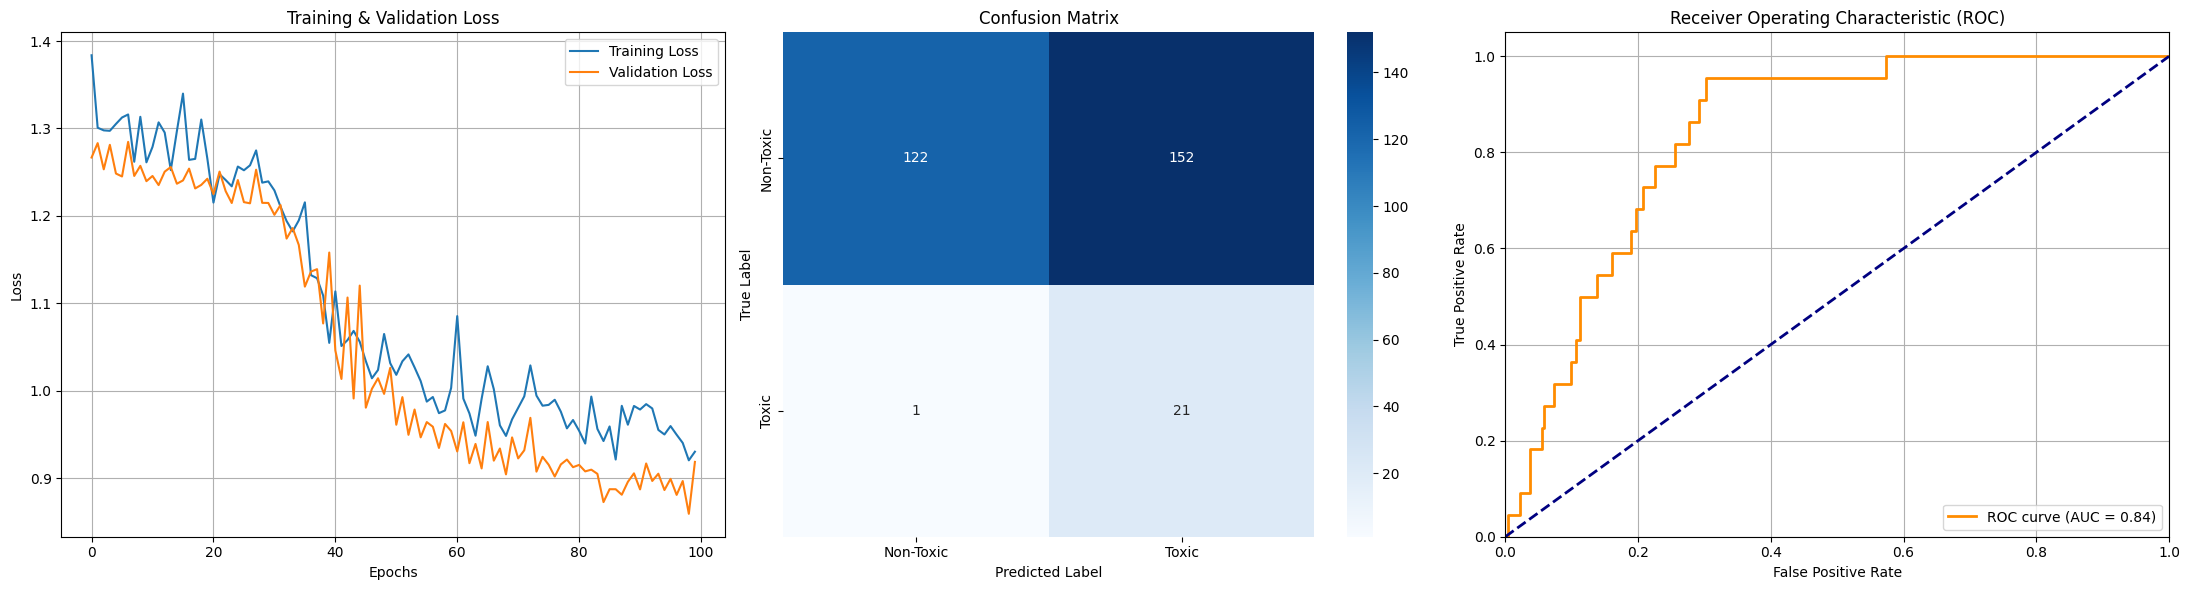

In [ ]:
# =============================================================================
# CELL 9: VISUALIZE RESULTS
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# 1. Plot Training vs. Validation Loss
axes[0].plot(history['train_loss'], label='Training Loss')
axes[0].plot(history['val_loss'], label='Validation Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# 2. Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
axes[1].set_title('Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# 3. ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver Operating Characteristic (ROC)')
axes[2].legend(loc="lower right")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# CELL 10: PREDICT ON NEW, UNSEEN DATA (FROM TOX21 DATASET)
# =============================================================================
import os
import pandas as pd
from torch_geometric.data import DataLoader

print("--- Testing the trained model on a new dataset ---")

# Step 1: Download a new dataset (Tox21)
NEW_DATA_URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz"
NEW_DATA_NAME = "tox21.csv.gz"
if not os.path.exists(NEW_DATA_NAME):
    print("Downloading new dataset (Tox21)...")
    !wget -q {NEW_DATA_URL}

# Step 2: Load the new data and prepare it
new_df = pd.read_csv(NEW_DATA_NAME)
new_df_task = new_df[['smiles', 'SR-p53']].dropna()
print(f"Loaded {len(new_df_task)} new molecules from the Tox21 SR-p53 task.")

# Step 3: Create a prediction function
def predict_toxicity(smiles_string):
    """Takes a SMILES string and returns the model's prediction."""
    model.load_state_dict(torch.load('best_model.pt'))
    model.to(device)
    model.eval()

    graph_data = smiles_to_graph(smiles_string, 0)
    if graph_data is None:
        return "Invalid SMILES String", 0.0

    loader = DataLoader([graph_data], batch_size=1, shuffle=False)

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            logit = model(data)
            probability = torch.sigmoid(logit).item()

    prediction = "Toxic" if probability > 0.5 else "Non-Toxic"

    return prediction, probability

# Step 4: Run predictions on a few examples
print("\n--- Running Predictions on Sample Molecules ---")
for i in range(5):
    smiles = new_df_task.iloc[i]['smiles']
    true_label = "Toxic" if new_df_task.iloc[i]['SR-p53'] == 1.0 else "Non-Toxic"

    predicted_label, score = predict_toxicity(smiles)

    print(f"\nMolecule {i+1}: {smiles}")
    print(f"  -> True Label from Dataset: {true_label}")
    print(f"  -> Model's Prediction: {predicted_label} (Confidence Score: {score:.2f})")

--- Testing the trained model on a new dataset ---
Loaded 6774 new molecules from the Tox21 SR-p53 task.

--- Running Predictions on Sample Molecules ---

Molecule 1: CCOc1ccc2nc(S(N)(=O)=O)sc2c1
  -> True Label from Dataset: Non-Toxic
  -> Model's Prediction: Toxic (Confidence Score: 0.62)

Molecule 2: CCN1C(=O)NC(c2ccccc2)C1=O
  -> True Label from Dataset: Non-Toxic
  -> Model's Prediction: Toxic (Confidence Score: 0.75)

Molecule 3: CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
  -> True Label from Dataset: Non-Toxic
  -> Model's Prediction: Toxic (Confidence Score: 0.61)

Molecule 4: CC(O)(P(=O)(O)O)P(=O)(O)O
  -> True Label from Dataset: Non-Toxic
  -> Model's Prediction: Toxic (Confidence Score: 0.56)

Molecule 5: CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
  -> True Label from Dataset: Non-Toxic
  -> Model's Prediction: Toxic (Confidence Score: 0.69)


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


--- Starting Full Evaluation on New Tox21 Dataset ---
Loaded 6774 molecules from the Tox21 SR-p53 task.
Processing new molecules into graphs...


  0%|          | 0/6774 [00:00<?, ?it/s]

[10:12:45] WARNING: not removing hydrogen atom without neighbors
[10:12:47] Explicit valence for atom # 3 Al, 6, is greater than permitted
[10:12:47] Explicit valence for atom # 4 Al, 6, is greater than permitted
[10:12:48] Explicit valence for atom # 4 Al, 6, is greater than permitted
[10:12:49] Explicit valence for atom # 9 Al, 6, is greater than permitted
[10:12:49] Explicit valence for atom # 5 Al, 6, is greater than permitted
[10:12:50] Explicit valence for atom # 16 Al, 6, is greater than permitted
[10:12:50] Explicit valence for atom # 20 Al, 6, is greater than permitted


Successfully processed 6767 new molecules.


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



--- Tox21 Test Set Performance ---
Accuracy:  0.2738
Precision: 0.0696
Recall:    0.8582
F1-Score:  0.1287
ROC AUC:   0.5849


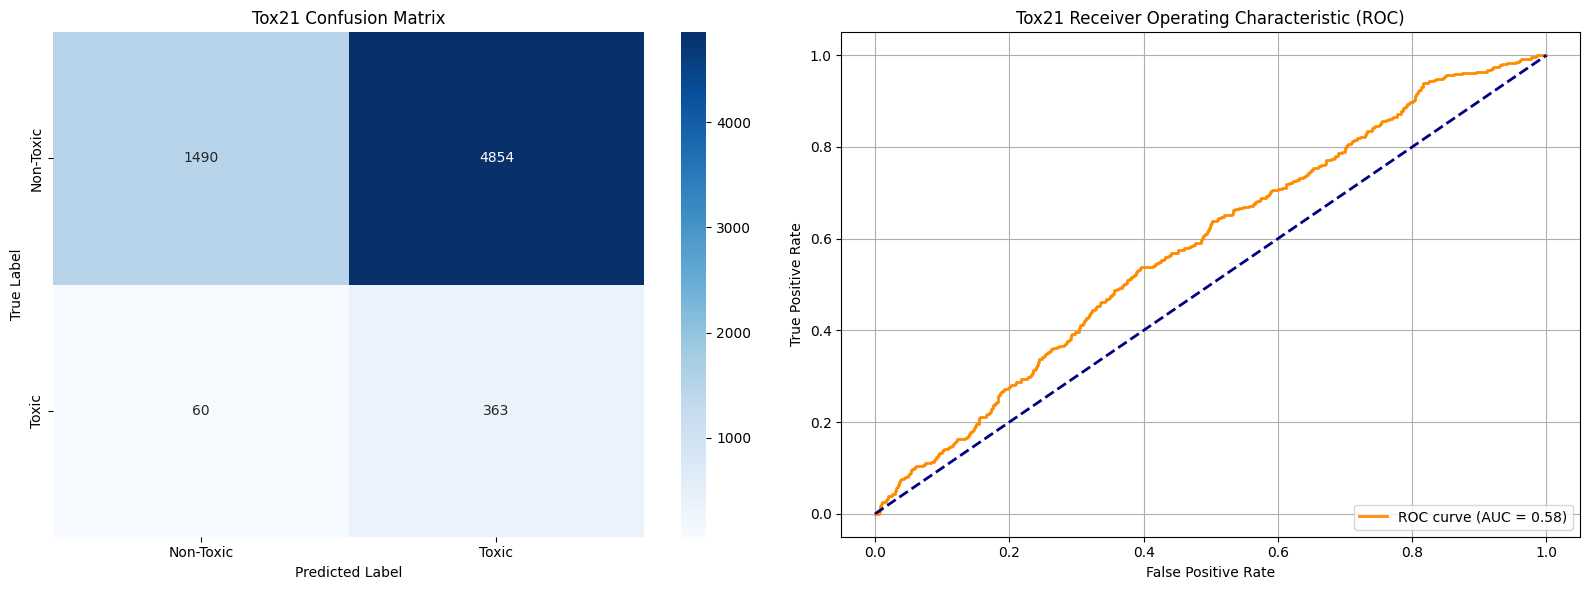

In [ ]:
# =============================================================================
# CELL 10: FULL EVALUATION ON A NEW DATASET (TOX21)
# =============================================================================
import os
import pandas as pd
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

print("--- Starting Full Evaluation on New Tox21 Dataset ---")

# Step 1: Download and Load the new dataset
NEW_DATA_URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz"
NEW_DATA_NAME = "tox21.csv.gz"
if not os.path.exists(NEW_DATA_NAME):
    !wget -q {NEW_DATA_URL}

new_df = pd.read_csv(NEW_DATA_NAME)
# We'll evaluate on the 'SR-p53' toxicity task
new_df_task = new_df[['smiles', 'SR-p53']].dropna()
print(f"Loaded {len(new_df_task)} molecules from the Tox21 SR-p53 task.")

# Step 2: Process ALL new molecules into graph objects
print("Processing new molecules into graphs...")
new_data_list = []
for _, row in tqdm(new_df_task.iterrows(), total=new_df_task.shape[0]):
    # The label is the 'SR-p53' column
    graph_data = smiles_to_graph(row['smiles'], row['SR-p53'])
    if graph_data:
        new_data_list.append(graph_data)

print(f"Successfully processed {len(new_data_list)} new molecules.")

# Step 3: Create a DataLoader for the entire new dataset
new_loader = DataLoader(new_data_list, batch_size=64, shuffle=False)

# Step 4: Load your trained model and run evaluation
model.load_state_dict(torch.load('best_model.pt'))
# The 'test' function is already defined in Cell 7
new_logits, new_labels = test(new_loader)

# Step 5: Calculate metrics for the new dataset
new_probs = torch.sigmoid(new_logits).cpu().numpy()
new_labels = new_labels.cpu().numpy()
new_preds = (new_probs > 0.5).astype(int)

accuracy = accuracy_score(new_labels, new_preds)
precision = precision_score(new_labels, new_preds)
recall = recall_score(new_labels, new_preds)
f1 = f1_score(new_labels, new_preds)
roc_auc = roc_auc_score(new_labels, new_probs)

print("\n--- Tox21 Test Set Performance ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# Step 6: Visualize the new results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix for Tox21
cm = confusion_matrix(new_labels, new_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
axes[0].set_title('Tox21 Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# ROC Curve for Tox21
fpr, tpr, _ = roc_curve(new_labels, new_probs)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_title('Tox21 Receiver Operating Characteristic (ROC)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()
plt.show()